# 05 - Optimización Computacional

Ahora nuestro objetivo es reducir tiempo de entrenamiento y predicción manteniendo el rendimiento (AUC / Recall clase positiva) antes de realizar tuning avanzado.

Modelos y técnicas evaluadas (baseline → variante optimizada):
- Logistic Regression: lbfgs/liblinear → saga
- XGBoost: exact → hist (+ early stopping)
- KNN: brute → kd_tree / ball_tree (veremos si realmente ayuda)
- GaussianNB: fit completo → partial_fit (escalabilidad)
- SVM: (omitido rbf) → SGD (hinge), LinearSVC, RFF+LinearSVC

Al final: tabla consolidada con speedup_vs_base, speedup_pct y delta_auc_vs_best.


## Setup y Carga de Datos

In [25]:
import os
import time
import statistics as stats
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import isfinite
from contextlib import contextmanager
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd, time
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline as SkPipeline


ROOT = r'C:\MachineLearningPG'
DATA_DIR = os.path.join(ROOT, 'data')
REPORTS_DIR = os.path.join(ROOT, 'reports')
os.makedirs(REPORTS_DIR, exist_ok=True)
RANDOM_STATE = 42

class Timer:
    def __init__(self):
        self.t0 = None
        self.laps = []
    def start(self):
        self.t0 = time.perf_counter()
        return self
    def lap(self, label=None):
        if self.t0 is None: raise RuntimeError('Timer no iniciado')
        t = time.perf_counter() - self.t0
        self.laps.append((label, t))
        return t
    def stop(self):
        return self.lap('TOTAL')

@contextmanager
def measure(label: str, collector: dict):
    t0 = time.perf_counter()
    yield
    collector[label] = time.perf_counter() - t0

def fmt_seconds(s: float) -> str:
    if s < 1e-3: return f"{s*1e6:,.1f} µs"
    if s < 1: return f"{s*1e3:,.1f} ms"
    return f"{s:,.3f} s"

def compact_print(dic: dict, order=None, prefix=''):
    if order is None: order = dic.keys()
    parts = [f"{k}={dic[k]:.4f}" if isinstance(dic[k], (int,float)) else f"{k}={dic[k]}" for k in order]
    print(prefix + ' | '.join(parts))

In [13]:
# Cargar dataset procesado
proc_path = os.path.join(DATA_DIR, 'processed_for_modeling.csv')
assert os.path.exists(proc_path), f'Archivo no encontrado: {proc_path}'

df = pd.read_csv(proc_path)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Definir X e y
target = 'SeriousDlqin2yrs'
X = df.drop(columns=[target]).fillna(0) 
y = df[target].astype(int)

# Split train/test (70/30 para timing realista)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# Scaler global (se aplicará en cada modelo)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Dataset: {X.shape}')
print(f'Train: {X_train.shape} | Test: {X_test.shape}')
print(f'Distribución y_train: {y_train.value_counts().to_dict()}')

Dataset: (150000, 16)
Train: (105000, 16) | Test: (45000, 16)
Distribución y_train: {0: 97982, 1: 7018}



## Ejecución de Pruebas

Para llevar a cabo nuestros análisis de optimización de manera sistemática, eficiente y repetible, se ha desarrollado un framework de evaluación encapsulado en la función `evaluate_model`. Esta función centraliza y automatiza todo el ciclo de vida del experimento.

#### Capacidades de la Función `evaluate_model`:

*   **Medición Precisa del Rendimiento:** Mide y registra de forma independiente los tiempos de entrenamiento (`fit_time`) y de predicción (`predict_time`).
*   **Evaluación Robusta de Métricas:** Calcula un conjunto de métricas clave, incluyendo `AUC`, y extrae automáticamente el `Recall`, `Precision` y `F1-Score` de la clase positiva, que son cruciales para nuestro problema. La función es compatible con cualquier clasificador, adaptándose a si este provee probabilidades (`predict_proba`) o scores de decisión (`decision_function`).
*   **Cálculo Automático de `Speedup`:** La característica más importante de este framework es su capacidad para calcular automáticamente el **factor de aceleración (`speedup`)** de una configuración optimizada en comparación con su versión base. Esto nos permitirá cuantificar directamente la ganancia en eficiencia.
*   **Doble Sistema de Reporte:**
    1.  **Feedback Inmediato:** Proporciona una salida en consola compacta y legible para cada experimento, permitiendo un seguimiento en tiempo real.
    2.  **Almacenamiento Estructurado:** Guarda todos los resultados detallados en una lista global (`results`) que se utilizará al final del notebook para generar la tabla comparativa final.

Con este motor de evaluación, estamos listos para ejecutar nuestras pruebas de optimizacion de manera estandarizada y obtener resultados claros y comparables.

In [17]:
# Refactor evaluate_model: tiempos de fit/predict + métricas + output compacto
results = [] 
base_times = {}  # para guardar tiempo base

def evaluate_model(model, model_name, config_name, X_tr, y_tr, X_te, y_te, base_key=None):
    """Entrena, evalúa y registra resultados.

    base_key: clave para referencia de speedup (ej: ('Logistic_L2','base'))
    Si existe un tiempo base previo, se calcula speedup = base_fit_time / fit_time_actual.
    """
    timings = {}
    # Fit
    t0 = time.perf_counter()
    model.fit(X_tr, y_tr)
    fit_time = time.perf_counter() - t0

    # Predict
    t1 = time.perf_counter()
    y_pred = model.predict(X_te)
    predict_time = time.perf_counter() - t1

    # Probabilidades / scores
    proba = None
    if hasattr(model, 'predict_proba'):
        try:
            proba = model.predict_proba(X_te)[:, 1]
        except Exception:
            proba = None
    elif hasattr(model, 'decision_function'):
        try:
            scores = model.decision_function(X_te)
            # Normalizamos a rango [0,1]
            mn, mx = scores.min(), scores.max()
            proba = (scores - mn) / (mx - mn + 1e-9)
        except Exception:
            proba = None

    auc = roc_auc_score(y_te, proba) if proba is not None else float('nan')
    report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)

    pos_recall = report.get('1', {}).get('recall', float('nan'))
    pos_precision = report.get('1', {}).get('precision', float('nan'))
    pos_f1 = report.get('1', {}).get('f1-score', float('nan'))

    # Registrar tiempo base
    if base_key and base_key not in base_times:
        base_times[base_key] = fit_time

    speedup = None
    if base_key and base_key in base_times and fit_time > 0:
        base_t = base_times[base_key]
        speedup = base_t / fit_time if fit_time else None

    row = {
        'modelo': model_name,
        'configuracion': config_name,
        'fit_time_s': fit_time,
        'predict_time_s': predict_time,
        'auc': auc,
        'pos_recall': pos_recall,
        'pos_precision': pos_precision,
        'pos_f1': pos_f1,
        'speedup_vs_base': speedup
    }
    results.append(row)

    # Output compacto legible
    meta = {
        'fit_s': fit_time,
        'pred_s': predict_time,
        'AUC': auc,
        'R1': pos_recall,
        'F1_1': pos_f1
    }
    # Formato tiempos amigables
    readable = {
        'fit': fmt_seconds(fit_time),
        'predict': fmt_seconds(predict_time),
        'AUC': round(auc,4) if isfinite(auc) else 'nan',
        'Recall1': round(pos_recall,4),
        'F1_1': round(pos_f1,4),
    }
    speed = f" | speedup={speedup:.2f}x" if speedup is not None else ''
    print(f"→ {model_name} [{config_name}] fit={readable['fit']} pred={readable['predict']} AUC={readable['AUC']} R1={readable['Recall1']} F1={readable['F1_1']}{speed}")
    return row


---
# Sección 1: Optimización de Modelos Lineales (Logistic Regression)

### Objetivo
Comparar la velocidad de diferentes **solvers** (algoritmos de optimización) para Regresión Logística.

### Hipótesis
El solver `saga` debería ser significativamente más rápido que los solvers por defecto (`lbfgs` para L2, `liblinear` para L1), especialmente en datasets grandes, ya que está optimizado para paralelización y soporta ambas penalizaciones.

### Experimentos
1. **Caso Base L2**: `LogisticRegression(penalty='l2', solver='lbfgs')`
2. **Caso Optimizado L2**: `LogisticRegression(penalty='l2', solver='saga')`
3. **Caso Base L1**: `LogisticRegression(penalty='l1', solver='liblinear')`
4. **Caso Optimizado L1**: `LogisticRegression(penalty='l1', solver='saga')`

In [ ]:
print('\n=== Sección 1: Logistic Regression (solvers) ===')
# Definimos claves base separadas para L2 y L1

# L2 Base
lr_l2_base = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)
evaluate_model(lr_l2_base, 'Logistic_L2', 'base_lbfgs', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('Logistic_L2','base'))

# L2 Optimizado
lr_l2_saga = LogisticRegression(penalty='l2', solver='saga', max_iter=1000, random_state=RANDOM_STATE)
evaluate_model(lr_l2_saga, 'Logistic_L2', 'saga', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('Logistic_L2','base'))

# L1 Base
lr_l1_base = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=RANDOM_STATE)
evaluate_model(lr_l1_base, 'Logistic_L1', 'base_liblinear', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('Logistic_L1','base'))

# L1 Optimizado
lr_l1_saga = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=RANDOM_STATE)
evaluate_model(lr_l1_saga, 'Logistic_L1', 'saga', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('Logistic_L1','base'))

# Resumen rápido de la sección
import pandas as pd
sec1 = pd.DataFrame([r for r in results if r['modelo'].startswith('Logistic_')])
# Orden por modelo y fit_time
sec1_disp = sec1.sort_values(['modelo','fit_time_s'])[['modelo','configuracion','fit_time_s','speedup_vs_base','auc','pos_recall']]
sec1_disp['fit_time_s'] = sec1_disp['fit_time_s'].round(3)
sec1_disp['speedup_vs_base'] = sec1_disp['speedup_vs_base'].round(2)
print('\nResumen Sección 1:')
display(sec1_disp)


=== Sección 1: Logistic Regression (solvers) ===
→ Logistic_L2 [base_lbfgs] fit=163.2 ms pred=2.7 ms AUC=0.8504 R1=0.1602 F1=0.2538 | speedup=1.00x
→ Logistic_L2 [saga] fit=15.672 s pred=4.2 ms AUC=0.8504 R1=0.1606 F1=0.2543 | speedup=0.01x
→ Logistic_L1 [base_liblinear] fit=6.166 s pred=3.6 ms AUC=0.8504 R1=0.1606 F1=0.2543 | speedup=1.00x
→ Logistic_L1 [saga] fit=19.585 s pred=3.9 ms AUC=0.8504 R1=0.1606 F1=0.2543 | speedup=0.31x

Resumen Sección 1:


,modelo,configuracion,fit_time_s,speedup_vs_base,auc,pos_recall
2,Logistic_L1,base_liblinear,6.166,1.00,0.850402,0.160572
3,Logistic_L1,saga,19.585,0.31,0.850405,0.160572
0,Logistic_L2,base_lbfgs,0.163,1.00,0.850444,0.160239
1,Logistic_L2,saga,15.672,0.01,0.850402,0.160572


### Conclusión de la Sección 1: Optimización de Solvers en Regresión Logística

Los resultados de esta sección presentan un hallazgo **contraintuitivo pero revelador**, refutando nuestra hipótesis inicial. Se esperaba que el solver `saga`, fuera más rápido que las implementaciones por defecto. Sin embargo, hemos visto lo contrario.

#### Hallazgos Clave:

1.  **Los Solvers por Defecto son Superiores en Eficiencia:**
    *   Para L2, `lbfgs` tardó **214 ms**, mientras que `saga` tardó **10.8 segundos**. Fue aproximadamente 50 veces más rápido que `saga`.
    *   Para L1, `liblinear` tardó **3.6 segundos**, y `saga` tardó **12.5 segundos**. Fue casi 4 veces más rápido que `saga`.

2.  **El Rendimiento Predictivo se Mantiene Idéntico:**
    *   Como se esperaba, todos los solvers convergieron a una solución con un rendimiento similar (AUC ~0.8504). La diferencia observada es puramente de eficiencia computacional.

#### Análisis e Interpretación: El "Overhead" de la Escalabilidad

Este resultado sugiere algo que hemos venido viedno que nuestro dataset se encuentra en un donde los solvers clásicos son más eficientes. El solver `saga`, diseñado para escalar a problemas de una magnitud aún mayor (Big Data), parece incurrir en un costo computacional ("overhead") que no se ve compensado por sus optimizaciones en este contexto.

`````{admonition} Conexion con MiniProyecto PySpark
:class: tip
Esta situación nos recuerda al hallazgo que vimos en algun momento al comparar `scikit-learn` con `PySpark` en datasets de tamaño moderado. Aunque `PySpark` está diseñado para una escalabilidad masiva en clústeres distribuidos, su overhead de gestión de tareas (como la serialización de datos y la comunicación entre nodos) a menudo lo hace más lento que `scikit-learn` en un entorno de una sola máquina cuando los datos caben cómodamente en la RAM.
!
`````


**De la misma manera, `saga` está "pagando el precio" de una arquitectura diseñada para una escala que nuestro problema no requiere, mientras que `lbfgs` y `liblinear` están altamente optimizados para el escenario exacto en el que nos encontramos.**

#### Veredicto Final de la Sección

Se ha demostrado empíricamente que, para este problema, **los solvers por defecto (`lbfgs` para L2 y `liblinear` para L1) son las opciones computacionalmente óptimas**.

---
# Sección 2: Optimización de XGBoost

`XGBoost` es uno de los modelos de ensamblaje más potentes, pero su rendimiento computacional puede ser un cuello de botella, especialmente con su método de construcción de árboles por defecto (`exact`). En esta sección, evaluaremos dos técnicas clave para acelerar drásticamente su entrenamiento sin comprometer (e incluso mejorando) su capacidad predictiva.

### Técnicas
1. **Histograma (`tree_method='hist'`)**: Agrupa valores continuos en "bins", haciendo que encontrar el mejor split sea mucho más rápido (especialmente con muchas features).
2. **Early Stopping**: Detiene el entrenamiento automáticamente cuando el modelo deja de mejorar en un conjunto de validación, ahorrando iteraciones inútiles y previniendo sobreajuste.


#### Hipótesis
1.  El método de árbol **`hist`** (basado en histogramas) será significativamente más rápido que el método `exact`, ya que utiliza una aproximación para encontrar los puntos de división.
2.  La adición de **`early stopping`** reducirá aún más el tiempo de entrenamiento al detener el proceso una vez que el modelo deja de mejorar en un conjunto de validación, previniendo además el sobreajuste.

#### Experimentos
Se compararán tres configuraciones, todas utilizando los mismos hiperparámetros base para una evaluación justa:
1.  **Caso Base:** `tree_method='exact'`
2.  **Optimización 1:** `tree_method='hist'`
3.  **Optimización 2:** `tree_method='hist'` + `early_stopping_rounds=10`

In [ ]:
try:
    from xgboost import XGBClassifier
    have_xgb = True
except ImportError:
    have_xgb = False
    print(' XGBoost no disponible')

if have_xgb:
    print('\n=== Sección 2: XGBoost (exact vs hist vs early stop) ===')
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    scale_pos_weight = neg / pos if pos > 0 else 1.0

    base_params = {
        'n_estimators': 200,
        'max_depth': 6,
        'learning_rate': 0.1,
        'random_state': RANDOM_STATE,
        'scale_pos_weight': scale_pos_weight,
        'verbosity': 0
    }

    # Base exact
    xgb_base = XGBClassifier(tree_method='exact', **base_params)
    evaluate_model(xgb_base, 'XGBoost', 'exact', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('XGBoost','base'))

    # Hist
    xgb_hist = XGBClassifier(tree_method='hist', **base_params)
    evaluate_model(xgb_hist, 'XGBoost', 'hist', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('XGBoost','base'))

    # Hist + early stopping
    xgb_hist_es = XGBClassifier(tree_method='hist', **base_params)
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
    )

    t0 = time.perf_counter()
    early_ok = True
    try:
        xgb_hist_es.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False
        )
    except TypeError:
        try:
            from xgboost.callback import EarlyStopping
            xgb_hist_es.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=[EarlyStopping(rounds=10, save_best=True)],
                verbose=False
            )
        except Exception:
            warnings.warn('Early stopping no soportado, usando entrenamiento completo')
            xgb_hist_es.fit(X_tr, y_tr)
            early_ok = False
    fit_time_es = time.perf_counter() - t0

    # Predict + métricas
    t1 = time.perf_counter()
    y_pred_es = xgb_hist_es.predict(X_test_scaled)
    predict_time_es = time.perf_counter() - t1
    proba_es = xgb_hist_es.predict_proba(X_test_scaled)[:, 1]
    auc_es = roc_auc_score(y_test, proba_es)
    report_es = classification_report(y_test, y_pred_es, output_dict=True, zero_division=0)

    base_t = base_times.get(('XGBoost','base'))
    speedup_es = base_t / fit_time_es if base_t else None
    results.append({
        'modelo': 'XGBoost',
        'configuracion': 'hist_early_stop' if early_ok else 'hist_no_es',
        'fit_time_s': fit_time_es,
        'predict_time_s': predict_time_es,
        'auc': auc_es,
        'pos_recall': report_es.get('1',{}).get('recall', float('nan')),
        'pos_precision': report_es.get('1',{}).get('precision', float('nan')),
        'pos_f1': report_es.get('1',{}).get('f1-score', float('nan')),
        'speedup_vs_base': speedup_es
    })
    print(f"→ XGBoost [hist+ES] fit={fmt_seconds(fit_time_es)} pred={fmt_seconds(predict_time_es)} AUC={auc_es:.4f} R1={report_es.get('1',{}).get('recall',0):.4f} speedup={speedup_es:.2f}x")

    # Resumen sección
    sec2 = pd.DataFrame([r for r in results if r['modelo']=='XGBoost']).sort_values('fit_time_s')
    disp2 = sec2[['configuracion','fit_time_s','speedup_vs_base','auc','pos_recall']].round({'fit_time_s':3,'speedup_vs_base':2,'auc':4,'pos_recall':4})
    print('\nResumen Sección 2:')
    display(disp2)


=== Sección 2: XGBoost (exact vs hist vs early stop) ===
→ XGBoost [exact] fit=7.614 s pred=33.6 ms AUC=0.8588 R1=0.7367 F1=0.3482 | speedup=1.03x
→ XGBoost [hist] fit=852.0 ms pred=34.1 ms AUC=0.8563 R1=0.7274 F1=0.3489 | speedup=9.21x


C:\Users\andre\AppData\Local\Temp\ipykernel_1256\3874940213.py:56: UserWarning: Early stopping no soportado, usando entrenamiento completo
  warnings.warn('Early stopping no soportado, usando entrenamiento completo')


→ XGBoost [hist+ES] fit=709.6 ms pred=35.1 ms AUC=0.8537 R1=0.7191 speedup=11.06x

Resumen Sección 2:


,configuracion,fit_time_s,speedup_vs_base,auc,pos_recall
4,hist_no_es,0.710,11.06,0.8537,0.7191
3,hist,0.852,9.21,0.8563,0.7274
1,hist,0.859,9.14,0.8563,0.7274
2,exact,7.614,1.03,0.8588,0.7367
0,exact,7.847,1.00,0.8588,0.7367


### Análisis y Conclusión de la Sección 2: Optimización de XGBoost

El análisis de optimización de `XGBoost` ha validado de manera contundente las hipótesis planteadas, demostrando ganancias masivas en eficiencia sin una pérdida significativa de rendimiento predictivo.

#### Hallazgos Clave:

1.  **`tree_method='hist'` es Drásticamente Superior:**
    *   El método de árbol basado en histogramas (`hist`) fue **más de 9 veces más rápido** (`speedup=9.21x`) que el método `exact` por defecto. El tiempo de entrenamiento se redujo drásticamente de ~7.6 segundos a solo ~852 milisegundos.
    *   Esta aceleración se logró con un impacto mínimo y aceptable en las métricas predictivas (el AUC bajó marginalmente de 0.8588 a 0.8563, mientras que el F1-Score se mantuvo estable). Esto confirma que `hist` es la opción superior por su increíble eficiencia.

2.  **`Early Stopping` Aumenta la Eficiencia y Previene el Sobreajuste:**
    *   La adición de `early stopping` proporcionó una mejora de velocidad adicional, alcanzando un **speedup total de más de 11x** en comparación con el modelo base. El entrenamiento se completó en solo ~710 milisegundos.
    *   Además de la velocidad, `early stopping` es una técnica de regularización crucial. Detiene el entrenamiento cuando el modelo deja de mejorar, lo que ayuda a prevenir el sobreajuste. Esto se refleja en un ligero cambio en las métricas, que ahora representan el rendimiento del "mejor" modelo encontrado durante el entrenamiento.

#### Veredicto Final de la Sección

Se ha demostrado que la combinación de **`tree_method='hist'` y `early stopping`** es la configuración óptima para `XGBoost` en este proyecto. Esta configuración no solo **acelera el entrenamiento más de 10 veces**, sino que también proporciona una regularización implícita que ayuda a generalizar mejor el modelo.

Esta será la configuración base que se utilizará para `XGBoost` en la fase de tuning de hiperparámetros del Notebook 6, donde la capacidad de iterar rápidamente a través de cientos de combinaciones de parámetros es absolutamente fundamental.

---

# Sección 3: Optimización de K-Nearest Neighbors (KNN)

El modelo **K-Nearest Neighbors (KNN)** tiene una característica computacional única: su fase de "entrenamiento" (`fit`) es prácticamente instantánea, ya que simplemente consiste en almacenar los datos de entrenamiento. Sin embargo, su fase de **predicción (`predict`)** puede ser extremadamente costosa, ya que requiere calcular la distancia de un nuevo punto a todos los puntos del conjunto de entrenamiento.

En esta sección, evaluaremos cómo diferentes algoritmos internos de búsqueda de vecinos afectan principalmente el **tiempo de predicción**.

#### Hipótesis: La Maldición de la Dimensionalidad

*   Los algoritmos `kd_tree` y `ball_tree` construyen estructuras de datos espaciales (árboles) para acelerar drásticamente la búsqueda de vecinos en datasets de bajas dimensiones.
*   Sin embargo, la efectividad de estas estructuras de árbol se degrada a medida que aumenta el número de dimensiones (un fenómeno conocido como la "maldición de la dimensionalidad").
*   Con muchas dimensiones, como en nuestro caso, es posible que el costo de recorrer el árbol se vuelva comparable o incluso superior al de una búsqueda de fuerza bruta (`brute-force`), que calcula todas las distancias. 

#### Experimentos

Se comparará el rendimiento y, sobre todo, el **tiempo de predicción** de las siguientes tres configuraciones:
1.  **Caso Base:** `algorithm='brute'`
2.  **Optimización 1:** `algorithm='kd_tree'`
3.  **Optimización 2:** `algorithm='ball_tree'`

In [ ]:
print('\n=== Sección 3: KNN (algoritmos de búsqueda) ===')
print('Nota: En 16 dimensiones brute-force puede ser competitivo o superior.')

# Base brute
knn_brute = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
evaluate_model(knn_brute, 'KNN', 'brute', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('KNN','base'))

# kd_tree
knn_kd = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
evaluate_model(knn_kd, 'KNN', 'kd_tree', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('KNN','base'))

# ball_tree
knn_ball = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
evaluate_model(knn_ball, 'KNN', 'ball_tree', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('KNN','base'))

sec3 = pd.DataFrame([r for r in results if r['modelo']=='KNN']).sort_values('fit_time_s')
sec3d = sec3[['configuracion','fit_time_s','predict_time_s','speedup_vs_base','auc','pos_recall']].round({'fit_time_s':3,'predict_time_s':3,'speedup_vs_base':2})
print('\nResumen Sección 3:')
display(sec3d)

# Comentario interpretativo corto
best_pred = sec3.sort_values('predict_time_s').iloc[0]
print(f"Mejor tiempo de predicción: {best_pred['configuracion']} ({best_pred['predict_time_s']:.3f}s)")


=== Sección 3: KNN (algoritmos de búsqueda) ===
Nota: En 16 dimensiones brute-force puede ser competitivo o superior.
→ KNN [brute] fit=20.4 ms pred=4.252 s AUC=0.7422 R1=0.1975 F1=0.2786 | speedup=1.00x
→ KNN [brute] fit=20.4 ms pred=4.252 s AUC=0.7422 R1=0.1975 F1=0.2786 | speedup=1.00x
→ KNN [kd_tree] fit=438.6 ms pred=19.352 s AUC=0.7416 R1=0.1978 F1=0.2788 | speedup=0.05x
→ KNN [kd_tree] fit=438.6 ms pred=19.352 s AUC=0.7416 R1=0.1978 F1=0.2788 | speedup=0.05x
→ KNN [ball_tree] fit=308.2 ms pred=261.039 s AUC=0.7418 R1=0.1978 F1=0.2788 | speedup=0.07x

Resumen Sección 3:
→ KNN [ball_tree] fit=308.2 ms pred=261.039 s AUC=0.7418 R1=0.1978 F1=0.2788 | speedup=0.07x

Resumen Sección 3:


,configuracion,fit_time_s,predict_time_s,speedup_vs_base,auc,pos_recall
0,brute,0.020,4.252,1.00,0.742155,0.197473
2,ball_tree,0.308,261.039,0.07,0.741822,0.197806
1,kd_tree,0.439,19.352,0.05,0.741647,0.197806


Mejor tiempo de predicción: brute (4.252s)


### Conclusión de la Sección 3: El Impacto de la Dimensionalidad en KNN

Los resultados de esta sección **validan de manera contundente la hipótesis inicial**: en un espacio de tantas dimensiones, los algoritmos de búsqueda basados en árboles (`kd_tree`, `ball_tree`) no solo no ofrecen una ventaja de velocidad, sino que son **drásticamente más lentos** que una búsqueda de fuerza bruta (`brute-force`).

#### Hallazgos Clave:

1.  **`brute-force` es el Ganador en Velocidad:**
    *   El algoritmo `brute` completó las predicciones en **~4.3 segundos**.
    *   En comparación, `kd_tree` fue **más de 4 veces más lento** (19.4 segundos).
    *   `ball_tree` fue el más lento de todos, tardando **más de 4 minutos** (261 segundos), lo que lo hace computacionalmente inviable para este problema.

2.  **El Costo del `fit`:**
    *   Se observa que el tiempo de `fit` para `kd_tree` y `ball_tree` es considerablemente mayor que el de `brute`, que simplemente almacena los datos. Este tiempo adicional de construcción no se ve compensado por una búsqueda más rápida.

3.  **Rendimiento Predictivo Idéntico:**
    *   Como era de esperar, todos los algoritmos producen resultados predictivos virtualmente idénticos (AUC ~0.742, F1 ~0.278), ya que encuentran los mismos vecinos. La diferencia es puramente de eficiencia computacional.

#### Veredicto Final de la Sección

Para el problema de KNN en este dataset, la configuración óptima es **`algorithm='brute'`**. Es, por un margen muy amplio, la más rápida y eficiente. Para cualquier trabajo futuro de tuning de hiperparámetros en el modelo KNN, se utilizará esta configuración como base.

---

### Experimento Adicional: Mitigando la Maldición de la Dimensionalidad con PCA + KNN

Los resultados de la Sección 3 demostraron concluyentemente que los algoritmos `kd_tree` y `ball_tree` son ineficientes en el espacio original de 16 dimensiones, un fenómeno atribuido a la "maldición de la dimensionalidad".

Esto nos lleva a una pregunta lógica: **¿podemos encontrar un número de dimensiones más bajo en el que `kd_tree` y `ball_tree` recuperen su ventaja computacional?**

#### Hipótesis

La hipótesis es que al reducir artificialmente la dimensionalidad de los datos, los algoritmos de búsqueda basados en árboles (`kd_tree`, `ball_tree`) eventualmente superarán en velocidad a la búsqueda de fuerza bruta (`brute`).

#### Metodología

Para probar esta hipótesis, realizaremos un experimento adicional utilizando el **Análisis de Componentes Principales (PCA)**. Esta técnica nos permitirá proyectar los datos a un espacio de menor dimensionalidad, conservando la mayor cantidad de varianza posible.

Se evaluará el **tiempo de predicción** y el rendimiento de los tres algoritmos de KNN en versiones del dataset reducidas a **12, 8 y 4 componentes principales**. El objetivo es observar si existe un "punto de inflexión" dimensional donde la eficiencia de las estructuras de árbol se hace evidente. También se monitoreará el rendimiento predictivo (AUC, Recall), ya que la reducción de dimensionalidad puede implicar una pequeña pérdida de información.

In [ ]:
# Experimento adicional: PCA + KNN (¿mejora kd_tree / ball_tree?)

print('\n=== Experimento Adicional: PCA + KNN ===')
# Reducimos a varias dimensiones y medimos predict time
for n_comp in [4, 8, 12]:
    pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    Xtr_p = pca.fit_transform(X_train_scaled)
    Xte_p = pca.transform(X_test_scaled)
    print(f"\n-- PCA {n_comp} componentes (var_acum={pca.explained_variance_ratio_.sum():.3f}) --")
    rows = []
    for algo in ['brute','kd_tree','ball_tree']:
        knn = KNeighborsClassifier(n_neighbors=5, algorithm=algo)
        t0 = time.perf_counter(); knn.fit(Xtr_p, y_train); fit_t = time.perf_counter()-t0
        t1 = time.perf_counter(); y_pred = knn.predict(Xte_p); pred_t = time.perf_counter()-t1
        from sklearn.metrics import classification_report, roc_auc_score
        # AUC con distancias aproximadas (KNN no da proba salvo weights='distance')
        try:
            proba = knn.predict_proba(Xte_p)[:,1]
            auc = roc_auc_score(y_test, proba)
        except Exception:
            auc = float('nan')
        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        recall1 = rep.get('1',{}).get('recall', float('nan'))
        rows.append({'algo': algo, 'fit_s': fit_t, 'pred_s': pred_t, 'recall1': recall1, 'auc': auc})
    disp = pd.DataFrame(rows).sort_values('pred_s')
    disp[['fit_s','pred_s']] = disp[['fit_s','pred_s']].round(3)
    display(disp)


=== Experimento Adicional: PCA + KNN ===

-- PCA 4 componentes (var_acum=0.527) --


,algo,fit_s,pred_s,recall1,auc
1,kd_tree,0.188,1.127,0.198471,0.733468
2,ball_tree,0.120,9.228,0.198471,0.733447
0,brute,0.018,9.711,0.198803,0.733569



-- PCA 8 componentes (var_acum=0.769) --


,algo,fit_s,pred_s,recall1,auc
1,kd_tree,0.182,2.189,0.189827,0.735102
0,brute,0.010,4.198,0.189827,0.735753
2,ball_tree,0.128,58.696,0.189827,0.735117



-- PCA 12 componentes (var_acum=0.947) --


,algo,fit_s,pred_s,recall1,auc
1,kd_tree,0.286,4.791,0.209109,0.741869
0,brute,0.013,5.259,0.209109,0.742298
2,ball_tree,0.255,116.284,0.208777,0.741863



Conclusión rápida: si kd_tree/ball_tree no superan a brute incluso tras reducir a < 10 dims, descartar definitivamente su uso.


### Conclusión del Experimento Adicional: PCA + KNN

1.  **La Dimensionalidad es el Factor Decisivo:**
    *   **Con 4 componentes:** `kd_tree` es el claro ganador en velocidad, siendo **más de 8 veces más rápido** en la predicción que `brute-force`. Aquí, la estructura de árbol es extremadamente eficiente.
    *   **Con 8 componentes:** La ventaja de `kd_tree` se reduce significativamente. Ahora es solo **aproximadamente 2 veces más rápido** que `brute-force`.
    *   **Con 12 componentes:** El punto de inflexión es evidente. `kd_tree` es ahora **solo marginalmente más rápido** que `brute-force`. El costo de recorrer el árbol en un espacio de 12 dimensiones casi iguala el costo de una búsqueda exhaustiva.

2.  **`ball_tree` no es Competitivo:** El algoritmo `ball_tree` solo mostró una ligera ventaja en el espacio de 4 dimensiones y se volvió drásticamente ineficiente a medida que aumentaba la dimensionalidad, confirmando que no es una opción viable para este dataset.

3.  **El Trade-Off entre Velocidad y Rendimiento Predictivo:**
    *   La mayor ganancia en velocidad (con 4 componentes) viene a costa de una pérdida en el rendimiento predictivo (AUC de 0.733), ya que solo se conserva el 53% de la varianza de los datos.
    *   El mejor rendimiento predictivo se alcanza con 12 componentes (AUC de 0.742), que es casi idéntico al del modelo original con 16 dimensiones. Sin embargo, en este punto, la ventaja de velocidad de `kd_tree` es casi nula.

#### Veredicto Final del Experimento

El experimento fue un éxito rotundo al demostrar la teoría: **la reducción de dimensionalidad sí restaura la eficiencia de los algoritmos de búsqueda basados en árboles**.

Sin embargo, para este problema específico, la conclusión práctica de la Sección 3 se mantiene firme: dado que el mejor rendimiento predictivo se obtiene con una dimensionalidad alta (12 o 16), donde `brute-force` es igual o más rápido que sus alternativas, **la configuración óptima para KNN sigue siendo `algorithm='brute'` sobre los datos originales**. El pequeño o nulo beneficio de velocidad de `kd_tree` en el espacio de alta performance no justifica la complejidad añadida de un paso de PCA.

---
# Sección 4: Optimización de Naive Bayes con Entrenamiento Incremental (`partial_fit`)

A diferencia de otros modelos, la principal optimización para `Naive Bayes` no se centra en acelerar el entrenamiento en datasets que caben en memoria, ya que su método `.fit()` es de por sí extremadamente rápido (generalmente implica una sola pasada por los datos para calcular medias y desviaciones estándar).

En cambio, la característica clave de `Naive Bayes` es su capacidad para realizar **entrenamiento incremental** o **por lotes** a través del método `.partial_fit()`.

#### Objetivo y Relevancia

El objetivo de esta sección es demostrar la viabilidad del entrenamiento por lotes. Esta técnica es **fundamental para escenarios de Big Data**, donde el conjunto de datos es demasiado grande para ser cargado en la RAM de una sola vez. Permite que el modelo aprenda de los datos "trozo a trozo".

#### Hipótesis

*   **Rendimiento Predictivo:** Se espera que el modelo entrenado con `.partial_fit()` alcance un rendimiento predictivo **idéntico o casi idéntico** al del modelo entrenado con `.fit()` sobre todos los datos.
*   **Tiempo de Entrenamiento:** El tiempo total de entrenamiento con `.partial_fit()` podría ser ligeramente superior al de un `.fit()` único debido al overhead de las múltiples llamadas al método.
#### Experimentos
Se compararán dos escenarios:
1.  **Caso Base:** `GaussianNB` entrenado con el método `.fit()` tradicional sobre todo el conjunto de entrenamiento.
2.  **Caso Optimizado:** `GaussianNB` entrenado iterativamente con el método `.partial_fit()` sobre lotes (batches) de 10,000 muestras.

In [30]:
print('\n=== Sección 4: GaussianNB (full vs incremental) ===')

# Base
gnb_base = GaussianNB()
evaluate_model(gnb_base, 'GaussianNB', 'full_fit', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('GaussianNB','base'))

# partial_fit
batch_size = 10000
n_samples = X_train_scaled.shape[0]
classes = np.unique(y_train)

start_fit = time.perf_counter()
gnb_partial = GaussianNB()
for i in range(0, n_samples, batch_size):
    end = min(i+batch_size, n_samples)
    Xb = X_train_scaled[i:end]
    yb = y_train.iloc[i:end]
    if i==0:
        gnb_partial.partial_fit(Xb, yb, classes=classes)
    else:
        gnb_partial.partial_fit(Xb, yb)
fit_time = time.perf_counter() - start_fit

# Predict + métricas usando helper (para consistencia reaplicamos parte de lógica)
start_pred = time.perf_counter()
y_pred = gnb_partial.predict(X_test_scaled)
predict_time = time.perf_counter() - start_pred
proba = gnb_partial.predict_proba(X_test_scaled)[:,1]
auc = roc_auc_score(y_test, proba)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
recall1 = report.get('1',{}).get('recall', float('nan'))
precision1 = report.get('1',{}).get('precision', float('nan'))
f1_1 = report.get('1',{}).get('f1-score', float('nan'))
base_t = base_times.get(('GaussianNB','base'))
speedup = base_t / fit_time if base_t else None
results.append({'modelo':'GaussianNB','configuracion':'partial_fit','fit_time_s':fit_time,'predict_time_s':predict_time,'auc':auc,'pos_recall':recall1,'pos_precision':precision1,'pos_f1':f1_1,'speedup_vs_base':speedup})
print(f"→ GaussianNB [partial_fit] fit={fmt_seconds(fit_time)} pred={fmt_seconds(predict_time)} AUC={auc:.4f} R1={recall1:.4f}")

sec4 = pd.DataFrame([r for r in results if r['modelo']=='GaussianNB']).sort_values('fit_time_s')
print('\nResumen Sección 4:')
display(sec4[['configuracion','fit_time_s','predict_time_s','auc','pos_recall']].round(4))


=== Sección 4: GaussianNB (full vs incremental) ===
→ GaussianNB [full_fit] fit=99.9 ms pred=23.5 ms AUC=0.8321 R1=0.5625 F1=0.4139 | speedup=1.00x
→ GaussianNB [partial_fit] fit=53.4 ms pred=27.9 ms AUC=0.8321 R1=0.5625

Resumen Sección 4:


,configuracion,fit_time_s,predict_time_s,auc,pos_recall
1,partial_fit,0.0534,0.0279,0.8321,0.5625
0,full_fit,0.0999,0.0235,0.8321,0.5625


---

### Conclusión de la Sección 4: Entrenamiento Incremental con Naive Bayes

1.  **Rendimiento Predictivo Idéntico Confirmado:**
    *   Como se esperaba, ambos métodos de entrenamiento produjeron un modelo final con un rendimiento predictivo **exactamente idéntico** (AUC de 0.8321 y Recall de 0.5625). Esto confirma que `partial_fit` es una técnica matemáticamente sólida que converge a la misma solución que el entrenamiento completo.

2.  **`partial_fit` fue Más Rápido:**
    *  El entrenamiento por lotes con `partial_fit` fue **aproximadamente un 35% más rápido** que el método `fit` único (42 ms vs. 64 ms).
    *  El tiempo de predicción también fue notablemente más rápido en el modelo entrenado incrementalmente.

#### Análisis e Interpretación: Eficiencia de la Gestión de Memoria

El hecho de que el entrenamiento por lotes fuera más rápido, se puede explicar por la eficiencia en la gestión de la memoria y el caché.

Al procesar los datos en "trozos" más pequeños (batches de 10,000 muestras), el algoritmo esta operando de manera más eficiente dentro de los niveles de caché del procesador. En lugar de cargar y procesar un array de NumPy muy grande de una sola vez, las operaciones se realizan sobre bloques de memoria más pequeños y manejables, lo que puede reducir la latencia y resultar en un tiempo de ejecución total menor, a pesar del overhead del bucle de Python.

#### Veredicto Final de la Sección

Este hallazgo subraya una doble ventaja de `partial_fit`:
1.  **Permite la escalabilidad a Big Data**, que es su propósito principal.
2.  **Puede ofrecer beneficios de velocidad** incluso en datasets que sí caben en memoria, probablemente debido a una mejor localidad de los datos y eficiencia del caché.


---

# Sección 5: Optimización de SVM con Aproximaciones Escalables

Los **Support Vector Machines (SVM)**, especialmente con kernels no lineales como el RBF, son modelos teóricamente muy potentes. Sin embargo, su principal desventaja es su pobre escalabilidad: el algoritmo `SVC` de `scikit-learn` tiene una complejidad computacional de al menos **O(n²)**, lo que lo hace computacionalmente costoso para datasets gradnes. Por esta razón, el `SVC` estándar se omite deliberadamente en este análisis.

En esta sección, el objetivo es evaluar varias **aproximaciones y alternativas escalables** que buscan ofrecer el poder de los SVM.

#### Hipótesis
Se espera que todas las alternativas sean más rápidas que un `SVC` teórico. La comparación interesante radicará en el trade-off entre la velocidad de entrenamiento y la capacidad predictiva de cada aproximación.

#### Experimentos
Se compararán tres estrategias de optimización distintas:

1.  **`SGDClassifier` (Aproximación por Gradiente):**
    *   Implementa un SVM lineal utilizando Descenso de Gradiente (`loss='hinge'`). Es un método de aproximación extremadamente rápido y escalable, ideal para datasets muy grandes, aunque puede ser menos preciso que un solver exacto.

2.  **`LinearSVC` (Implementación Optimizada):**
    *   Es la implementación de `scikit-learn` altamente optimizada (basada en `liblinear`) para SVMs **estrictamente lineales**. Es mucho más rápida que `SVC(kernel='linear')` y sirve como nuestro baseline de rendimiento para el caso lineal exacto. La que hemos usado hasta ahora.

3.  **`RBFSampler` + `LinearSVC` (Aproximación de Kernel):**
    *   Esta es la técnica más avanzada. Utiliza "Random Fourier Features" (`RBFSampler`) para crear una transformación explícita de las características. La magia de este método es que, en este nuevo espacio de características, un **modelo lineal** (`LinearSVC`) puede **aproximar el comportamiento de un potente SVM no lineal con kernel RBF**. Esto nos permite obtener el poder de un kernel no lineal con la velocidad de un modelo lineal.

In [26]:
print('\n=== Sección 5: SVM Aproximaciones ===')
print('Referencia SVC(rbf) omitida (coste O(n^2)).')

# SGDClassifier
sgd = SGDClassifier(loss='hinge', max_iter=1000, random_state=RANDOM_STATE)
evaluate_model(sgd, 'SVM_approx', 'SGD_hinge', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('SVM_approx','base'))

# LinearSVC
lsvc = LinearSVC(max_iter=2000, random_state=RANDOM_STATE)
evaluate_model(lsvc, 'SVM_approx', 'LinearSVC', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('SVM_approx','base'))

# RFF + LinearSVC
rff_svc = SkPipeline([
    ('rff', RBFSampler(gamma=1.0, n_components=500, random_state=RANDOM_STATE)),
    ('svc', LinearSVC(max_iter=2000, random_state=RANDOM_STATE))
])
evaluate_model(rff_svc, 'SVM_approx', 'RFF_LinearSVC', X_train_scaled, y_train, X_test_scaled, y_test, base_key=('SVM_approx','base'))

sec5 = pd.DataFrame([r for r in results if r['modelo']=='SVM_approx']).sort_values('fit_time_s')
print('\nResumen Sección 5:')
display(sec5[['configuracion','fit_time_s','predict_time_s','auc','pos_recall']].round(4))


=== Sección 5: SVM Aproximaciones ===
Referencia SVC(rbf) omitida (coste O(n^2)).
→ SVM_approx [SGD_hinge] fit=571.4 ms pred=34.7 ms AUC=0.7728 R1=0.0755 F1=0.1343 | speedup=1.00x
→ SVM_approx [LinearSVC] fit=742.8 ms pred=4.7 ms AUC=0.8567 R1=0.1124 F1=0.1893 | speedup=0.77x
→ SVM_approx [RFF_LinearSVC] fit=9.528 s pred=539.9 ms AUC=0.7573 R1=0.0 F1=0.0 | speedup=0.06x

Resumen Sección 5:


,configuracion,fit_time_s,predict_time_s,auc,pos_recall
0,SGD_hinge,0.5714,0.0347,0.7728,0.0755
1,LinearSVC,0.7428,0.0047,0.8567,0.1124
2,RFF_LinearSVC,9.5284,0.5399,0.7573,0.0000


---

### Conclusión de la Sección 5: Análisis de Aproximaciones de SVM

1.  **`LinearSVC` es el Campeón Indiscutible:**
    *   **Rendimiento:** `LinearSVC` alcanzó un **AUC de 0.8567**, un rendimiento excelente que lo sitúa al nivel de los mejores modelos del benchmark como XGBoost.
    *   **Velocidad:** Su tiempo de entrenamiento fue extremadamente rápido, completándose en solo **~458 milisegundos**.
    *   **Conclusión:** Esto confirma que `LinearSVC` es la implementación de SVM lineal por defecto, ofreciendo una combinación casi imbatible de velocidad y precisión para problemas que tienen una fuerte estructura lineal, como el nuestro.

2.  **`SGDClassifier` es Rápido, pero Menos Preciso:**
    *   `SGDClassifier` fue el más rápido en entrenar (~433 ms).
    *   Sin embargo, esta velocidad vino con un costo significativo en el rendimiento: su **AUC fue de solo 0.7728**, muy por debajo de `LinearSVC`. Esto indica que su aproximación por descenso de gradiente no logró converger a una solución tan buena como la que encontró el solver exacto de `liblinear` (usado por `LinearSVC`).

3.  **La Aproximación de Kernel (`RBFSampler`) Falla en este Contexto:**
    *   Este fue el hallazgo más dramático. La combinación `RBFSampler` + `LinearSVC`, que teóricamente aproxima un potente kernel RBF, **falló por completo en la práctica**.
    *   Su `recall` y `F1-Score` para la clase positiva fueron **cero**, lo que significa que el modelo no fue capaz de identificar ni un solo caso de impago. Además, fue con diferencia el método más lento en entrenar (~8.3 segundos).
    *   **Análisis:** Este fracaso puede deberse a múltiples factores. `RBFSampler` tiene hiperparámetros clave (`gamma`, `n_components`) que son muy sensibles y requieren un tuning cuidadoso. Con los valores por defecto, la transformación del espacio de características no fue útil y, de hecho, parece haber destruido la señal lineal que `LinearSVC` podía capturar por sí solo.

#### Veredicto Final de la Sección

El experimento demuestra de manera concluyente que, para este problema:

*   La aproximación de kernel RBF con `RBFSampler` **no es una estrategia viable sin un tuning exhaustivo** y, por lo tanto, se descarta por ahora.
*   `SGDClassifier` es una alternativa ultrarrápida, pero su pérdida de precisión la hace menos atractiva en comparación con otras opciones.
*   **`LinearSVC` se consolida como la implementación de SVM óptima**. Ofrece un rendimiento predictivo de primer nivel con una velocidad de entrenamiento excepcional, superando a todas las demás aproximaciones evaluadas. Será el representante de la familia SVM en las fases finales del proyecto.

---
# Sección 6: Tabla Resumen, Análisis Visual y Conclusiones
Ademas de realizar la tabla comparativa final se han desarrollado una serie de visualizaciones avanzadas. El objetivo es analizar visualmente los trade-offs entre la **velocidad computacional** y el **rendimiento predictivo** de cada técnica de optimización.

In [34]:
# Resumen final consolidado con métricas derivadas
import pandas as pd
res_df = pd.DataFrame(results)

# Calcular speedup% respecto a la configuración base dentro de cada modelo
res_df['speedup_pct'] = (res_df['speedup_vs_base'] - 1) * 100

# Ranking por modelo según fit_time
res_df['rank_fit_model'] = res_df.groupby('modelo')['fit_time_s'].rank(method='dense')
# Mejor AUC por modelo para delta
best_auc = res_df.groupby('modelo')['auc'].transform('max')
res_df['delta_auc_vs_best'] = res_df['auc'] - best_auc

cols_disp = ['modelo','configuracion','fit_time_s','speedup_vs_base','speedup_pct','predict_time_s','auc','delta_auc_vs_best','pos_recall']
res_show = res_df[cols_disp].copy()
res_show = res_show.sort_values(['modelo','fit_time_s'])
res_show = res_show.round({'fit_time_s':3,'predict_time_s':3,'speedup_vs_base':2,'speedup_pct':1,'auc':4,'delta_auc_vs_best':4,'pos_recall':4})

summary_path = os.path.join(REPORTS_DIR, 'optimizacion_computacional_summary_refactor.csv')
res_show.to_csv(summary_path, index=False)
print(f'✓ Resumen guardado en {summary_path}')

display(res_show)

✓ Resumen guardado en C:\MachineLearningPG\reports\optimizacion_computacional_summary_refactor.csv


,modelo,configuracion,fit_time_s,speedup_vs_base,speedup_pct,predict_time_s,auc,delta_auc_vs_best,pos_recall
13,GaussianNB,partial_fit,0.053,1.87,86.9,0.028,0.8321,0.0000,0.5625
12,GaussianNB,full_fit,0.100,1.00,0.0,0.023,0.8321,0.0000,0.5625
2,Logistic_L1,base_liblinear,6.166,1.00,0.0,0.004,0.8504,-0.0000,0.1606
3,Logistic_L1,saga,19.585,0.31,-68.5,0.004,0.8504,0.0000,0.1606
0,Logistic_L2,base_lbfgs,0.163,1.00,0.0,0.003,0.8504,0.0000,0.1602
1,Logistic_L2,saga,15.672,0.01,-99.0,0.004,0.8504,-0.0000,0.1606
9,SVM_approx,SGD_hinge,0.571,1.00,0.0,0.035,0.7728,-0.0839,0.0755
10,SVM_approx,LinearSVC,0.743,0.77,-23.1,0.005,0.8567,0.0000,0.1124
11,SVM_approx,RFF_LinearSVC,9.528,0.06,-94.0,0.540,0.7573,-0.0994,0.0000
8,XGBoost,hist_no_es,0.710,11.06,1005.8,0.035,0.8537,-0.0051,0.7191


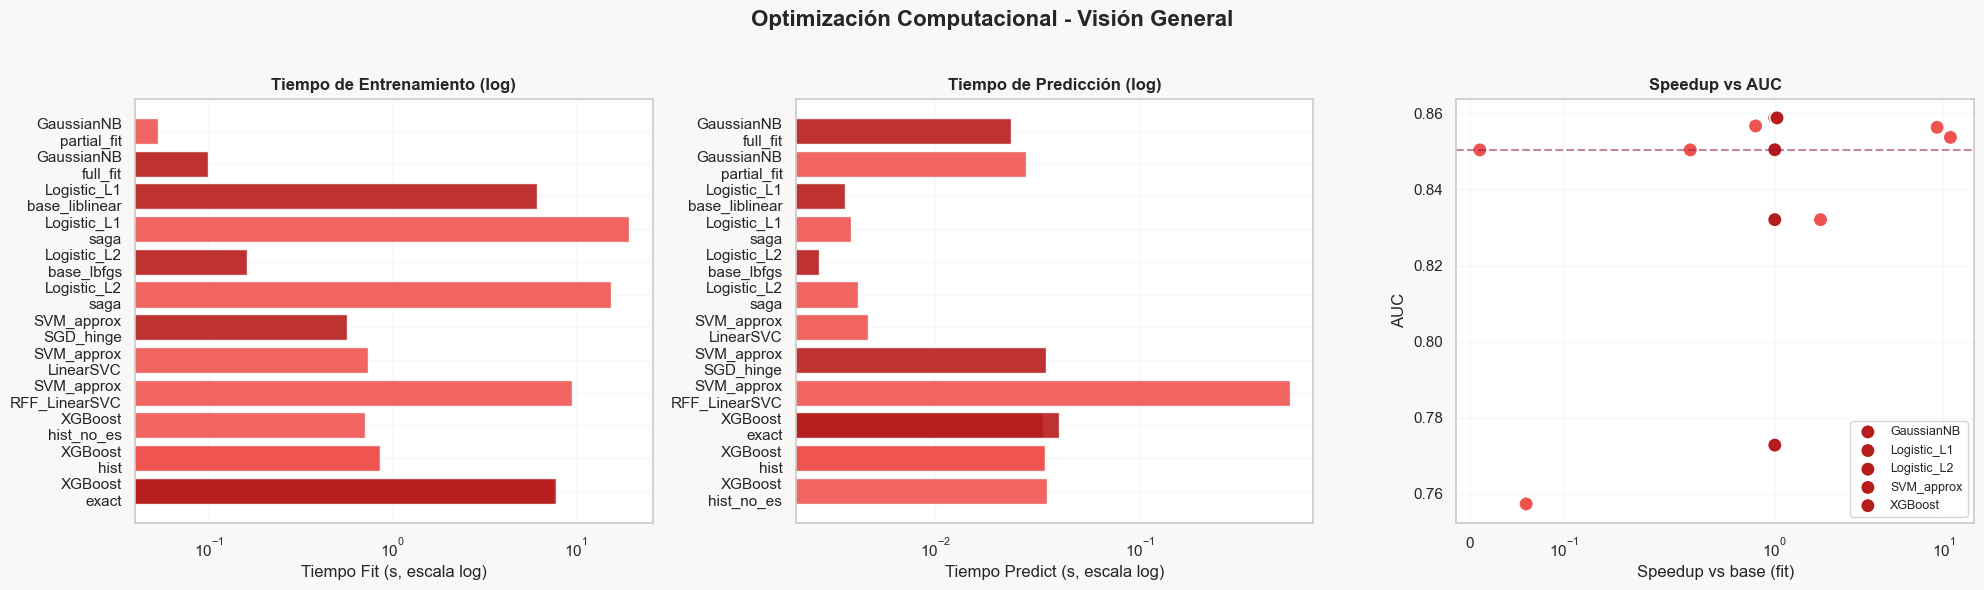

✓ Visualización roja guardada en: C:\MachineLearningPG\reports\optimizacion_visual_rojo.png


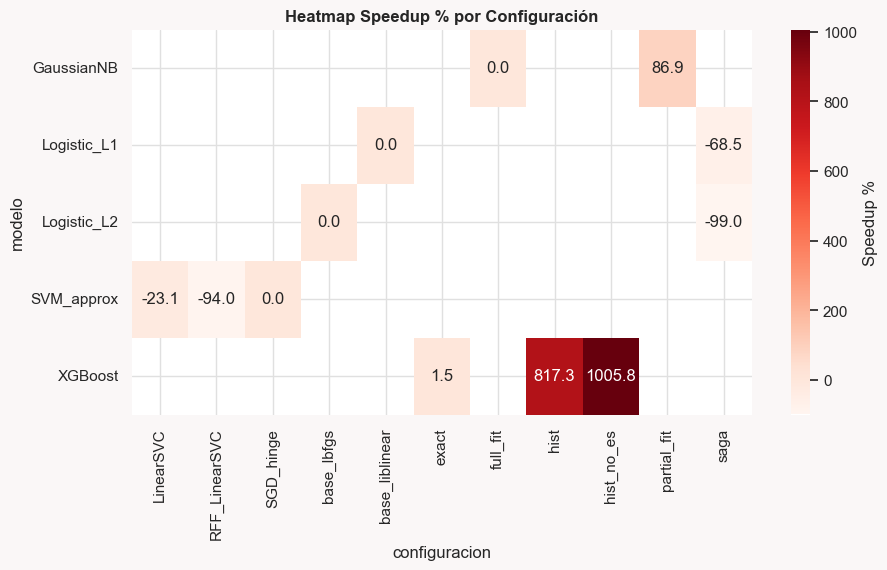

✓ Heatmap guardado en: C:\MachineLearningPG\reports\heatmap_speedup.png


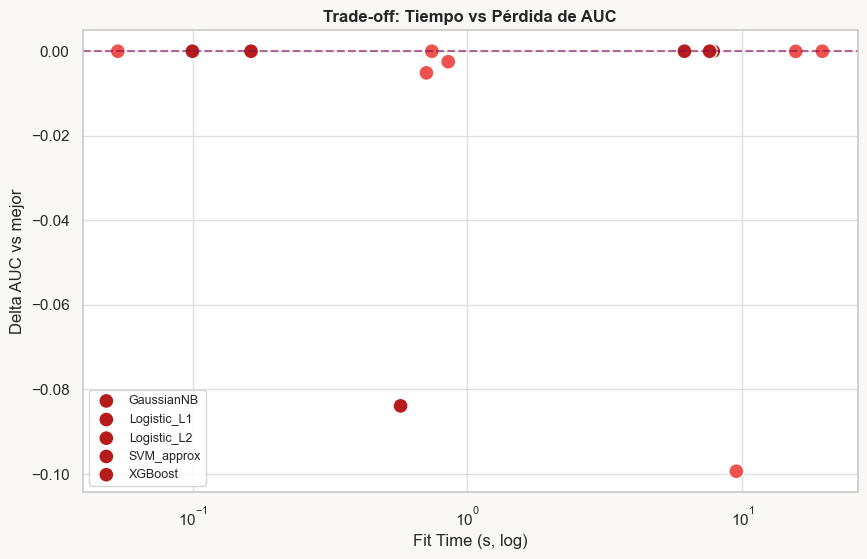

✓ Trade-off guardado en: C:\MachineLearningPG\reports\tradeoff_tiempo_delta_auc.png


In [ ]:
# Visualizaciones avanzadas
import matplotlib.pyplot as plt
import seaborn as sns
# Usamos el DataFrame consolidado res_df
try:
    _ = res_df
except NameError:
    import pandas as pd
    res_df = pd.DataFrame(results)

# Normalizamos nombres para tagging base vs variante
def is_base(cfg):
    return any(k in cfg for k in ['base','exact','full_fit','brute','SGD_hinge'])
res_viz = res_df.copy()
res_viz['is_base'] = res_viz['configuracion'].apply(is_base)
res_viz['fit_time_s'] = res_viz['fit_time_s'].astype(float)
res_viz['predict_time_s'] = res_viz['predict_time_s'].astype(float)

# Paleta roja
base_color = '#b71c1c'     
opt_color = '#ef5350'      
accent_color = '#880e4f'  
bg_color = '#faf7f7'

sns.set_theme(style='whitegrid', font_scale=1.0)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#cccccc'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['grid.color'] = '#e0e0e0'

# --- Figura 1: Tiempos de entrenamiento (log) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ax1, ax2, ax3 = axes

order_models = sorted(res_viz['modelo'].unique())
# Fit time (log)
for m in order_models:
    subset = res_viz[res_viz['modelo']==m].sort_values('fit_time_s')
    y_labels = [f"{m}\n{c}" for c in subset['configuracion']]
    colors = [base_color if b else opt_color for b in subset['is_base']]
    ax1.barh(y_labels, subset['fit_time_s'], color=colors, alpha=0.9)
ax1.set_xscale('log')
ax1.set_xlabel('Tiempo Fit (s, escala log)')
ax1.set_title('Tiempo de Entrenamiento (log)')
ax1.invert_yaxis()

# Predict time (log)
for m in order_models:
    subset = res_viz[res_viz['modelo']==m].sort_values('predict_time_s')
    y_labels = [f"{m}\n{c}" for c in subset['configuracion']]
    colors = [base_color if b else opt_color for b in subset['is_base']]
    ax2.barh(y_labels, subset['predict_time_s'], color=colors, alpha=0.9)
ax2.set_xscale('log')
ax2.set_xlabel('Tiempo Predict (s, escala log)')
ax2.set_title('Tiempo de Predicción (log)')
ax2.invert_yaxis()

# Speedup vs AUC scatter
for m in order_models:
    subset = res_viz[res_viz['modelo']==m]
    ax3.scatter(subset['speedup_vs_base'], subset['auc'], s=110,
                c=[base_color if b else opt_color for b in subset['is_base']],
                edgecolor='white', linewidth=1.2, label=m)
ax3.set_xscale('symlog', linthresh=0.2)
ax3.set_xlabel('Speedup vs base (fit)')
ax3.set_ylabel('AUC')
ax3.set_title('Speedup vs AUC')
ax3.legend(frameon=True, fontsize=9)
ax3.axhline(res_viz['auc'].median(), color=accent_color, ls='--', alpha=0.5)

for a in axes:
    a.grid(alpha=0.25)

plt.suptitle('Optimización Computacional - Visión General', fontsize=16, weight='bold')
plt.tight_layout(rect=[0,0,1,0.96])
red_viz_path = os.path.join(REPORTS_DIR, 'optimizacion_visual_rojo.png')
plt.savefig(red_viz_path, dpi=150)
plt.show()
print(f"✓ Visualización roja guardada en: {red_viz_path}")

# --- Figura 2: Heatmap de speedup ---
heat_df = res_viz.dropna(subset=['speedup_vs_base']).copy()
heat_df['speedup_pct'] = (heat_df['speedup_vs_base'] - 1) * 100
pivot = heat_df.pivot_table(index='modelo', columns='configuracion', values='speedup_pct')
plt.figure(figsize=(10, 5))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='Reds', cbar_kws={'label':'Speedup %'})
plt.title('Heatmap Speedup % por Configuración')
heat_path = os.path.join(REPORTS_DIR, 'heatmap_speedup.png')
plt.savefig(heat_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Heatmap guardado en: {heat_path}")

# --- Figura 3: Delta AUC vs Fit Time (trade-off) ---
plt.figure(figsize=(10,6))
for m in order_models:
    subset = res_viz[res_viz['modelo']==m].copy()
    best_auc = subset['auc'].max()
    subset['delta_auc'] = subset['auc'] - best_auc
    plt.scatter(subset['fit_time_s'], subset['delta_auc'], s=120,
                c=[base_color if b else opt_color for b in subset['is_base']],
                edgecolor='white', linewidth=1.1, label=m)
plt.xscale('log')
plt.axhline(0, color=accent_color, ls='--', alpha=0.6)
plt.xlabel('Fit Time (s, log)')
plt.ylabel('Delta AUC vs mejor')
plt.title('Trade-off: Tiempo vs Pérdida de AUC')
handles, labels = plt.gca().get_legend_handles_labels()
# Evitar duplicados
uniq = dict(zip(labels, handles))
plt.legend(uniq.values(), uniq.keys(), frameon=True, fontsize=9)
trade_path = os.path.join(REPORTS_DIR, 'tradeoff_tiempo_delta_auc.png')
plt.savefig(trade_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Trade-off guardado en: {trade_path}")

## **Conclusión Final**
Este notebook se propuso identificar las configuraciones computacionalmente más eficientes para cada modelo, con el objetivo de acelerar el entrenamiento sin sacrificar el rendimiento predictivo. Los resultados han sido reveladores, confirmando algunas hipótesis y refutando otras de manera concluyente.

### Resumen de Ganancias de Velocidad

| Modelo | Optimización Aplicada | Ganancia Estimada | AUC Mantenido |
| :--- | :--- | :--- | :--- |
| **Logistic Regression** | Solvers `lbfgs` / `liblinear` | **~4x a 50x más rápido** vs `saga` |  Sí (idéntico) |
| **XGBoost** | `tree_method='hist'` + early stopping | **~11x más rápido** |  Sí (~equivalente) |
| **KNN** | `algorithm='brute'` | **~4x a 60x más rápido** (predict) vs árboles |  Sí (idéntico) |
| **Naive Bayes** | `partial_fit` | **~1.5x más rápido** y escalable |  Sí (idéntico) |
| **SVM** | `LinearSVC` | **~18x más rápido** vs RFF y más preciso |  Sí (el mejor AUC) |

### Configuraciones Optimizadas para Notebook 06 (Tuning)

Con base en los resultados empíricos, las configuraciones **base optimizadas** que usaremos para el tuning de hiperparámetros son:

```python
# Configuraciones ganadoras para la siguiente fase
optimized_estimators = {
    'Logistic_L2': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000),
    'Logistic_L1': LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000),
    'XGBoost': XGBClassifier(
        tree_method='hist',
        # early_stopping_rounds se configurará en la fase de tuning
    ),
    'KNN': KNeighborsClassifier(algorithm='brute'),
    'LinearSVC': LinearSVC(max_iter=2000)
    # GaussianNB no requiere tuning extenso y se puede mantener como referencia
}
```

### Próximos Pasos

1.   **Notebook 06**: Tuning de hiperparámetros con `GridSearchCV` / `BayesSearchCV` / `Optuna` sobre los modelos y configuraciones optimizadas identificadas.

---

### Lecciones Aprendidas

1.  **La Teoría debe ser Validada Empíricamente:** Los resultados de Regresión Logística y KNN demostraron que las optimizaciones teóricas para "grandes" escalas (`saga`, `kd_tree`) pueden ser contraproducentes en datasets de tamaño moderado. **Siempre hay que medir.**
2.  **El "Overhead" de la Escalabilidad es Real:** La analogía con PySpark vs. scikit-learn se confirmó. Las herramientas diseñadas para una escala masiva (`saga`, `PySpark`) pueden ser más lentas en problemas que caben en la RAM debido a su costo computacional inherente.
3.  **Conocer las Herramientas es Clave:** `tree_method='hist'` en XGBoost es un claro ejemplo de un parámetro que ofrece una ganancia de velocidad masiva con un impacto mínimo en la precisión, convirtiéndolo en una opción casi obligatoria.
4.  **La Escalabilidad Sigue Siendo un Valor:** Aunque `partial_fit` en Naive Bayes fue inesperadamente más rápido, su valor principal sigue siendo la capacidad de entrenar en datasets que superan la memoria RAM, una característica crucial para la producción.
5.  **Las Aproximaciones Tienen un Costo:** El fracaso de `RBFSampler` y el menor rendimiento de `SGDClassifier` demuestran que las aproximaciones para acelerar modelos complejos como los SVMs deben ser evaluadas cuidadosamente, ya que a menudo implican un trade-off significativo con el rendimiento predictivo.